In [4]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastbook
from fastbook import *
import numpy as np
import pandas as pd
fastbook.setup_book()
import os
import ipywidgets

In [3]:
path=untar_data(URLs.PASCAL_2012)

In [5]:
path

Path('C:/Users/mayan/.fastai/data/pascal_2012')

In [7]:
df=pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [8]:
dblock=DataBlock()

In [10]:
dsets=dblock.datasets(df)

In [11]:
len(dsets.train),len(dsets.valid)

(9232, 2308)

In [12]:
x,y=dsets.train[0]
x,y

(fname                       2008_007585.jpg
 labels      bottle diningtable chair person
 is_valid                               True
 Name: 3746, dtype: object,
 fname                       2008_007585.jpg
 labels      bottle diningtable chair person
 is_valid                               True
 Name: 3746, dtype: object)

In [13]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock=DataBlock(get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/mayan/.fastai/data/pascal_2012/train/2008_004610.jpg'),
 ['train'])

In [14]:
dblock=DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                get_x=get_x,
                get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]))

In [16]:
idx=torch.where(dsets.train[0][1]==1.0)[0]
dsets.train.vocab[idx]

(#2) ['motorbike','person']

In [18]:
def splitter(df):
    train=df.index[~df['is_valid']].tolist()
    valid=df.index[df['is_valid']].tolist()
    return train,valid
dblock=DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                splitter=splitter,
                get_x=get_x,
                get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x442,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]))

In [25]:
dblock=DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                splitter=splitter,
                get_x=get_x,
                get_y=get_y,
                item_tfms=RandomResizedCrop(128,min_scale=0.35))
dls=dblock.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


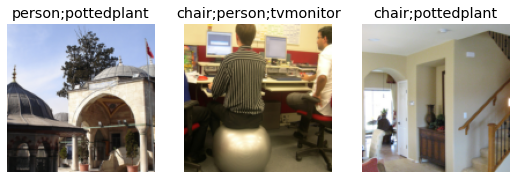

In [26]:
dls.show_batch(nrows=1,ncols=3)

In [27]:
learn=cnn_learner(dls,resnet18)

In [28]:
x,y=to_cpu(dls.train.one_batch())
activs=learn.model(x)
activs.shape

torch.Size([64, 20])

In [29]:
activs[0]

TensorBase([-6.4773e-01, -1.2563e+00, -1.0589e+00, -2.1999e-03, -5.0112e-01, -7.7066e-03,  1.3289e+00,  3.7595e+00, -1.2942e+00, -3.1951e+00, -4.0091e-01, -1.4181e+00,  7.8862e-01, -5.5148e+00,
        -2.1818e+00, -2.4839e+00,  1.2085e+00, -3.8371e+00, -3.5140e-01,  1.1144e+00], grad_fn=<AliasBackward0>)

In [30]:
def binary_cross_entropy(inputs,targets):
    inputs=inputs.sigmoid()
    return -torch.where(targets==1,1-inputs,inputs).log().mean()

In [31]:
loss_func=nn.BCEWithLogitsLoss()
loss=loss_func(activs,y)
loss

TensorMultiCategory(1.0556, grad_fn=<AliasBackward0>)

In [32]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.866285,0.616889,0.233454,12:21
1,0.577141,0.226133,0.759505,12:25
2,0.230874,0.114183,0.946127,12:14
3,0.144705,0.104258,0.950240,12:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.116284,0.102921,0.949751,14:22
1,0.101620,0.094726,0.955830,14:20
2,0.081560,0.091565,0.957024,14:21


In [33]:
learn.metrics=partial(accuracy_multi,thresh=0.1)
learn.validate()

(#2) [0.09156451374292374,0.935986340045929]

In [34]:
learn.metrics=partial(accuracy_multi,thresh=0.99)
learn.validate()

(#2) [0.09156451374292374,0.9481281638145447]

In [35]:
preds,targs=learn.get_preds()

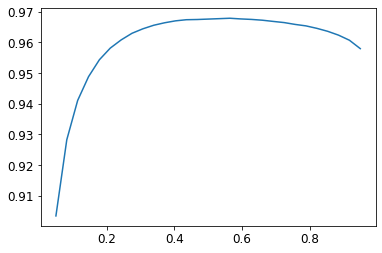

In [36]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [38]:
learn.export(fname='MultiCat Predictor.pkl')
path=Path()
path.ls(file_exts='.pkl')

(#3) [Path('Cars_Predictor.pkl'),Path('MultiCat Predictor.pkl'),Path('shoes_model.pkl')]

In [43]:
learn_pred=load_learner(path/'MultiCat Predictor.pkl')
learn_pred.predict('E:/Coding/Github/FastAI/Cars/BMW/00000003.jpg')

((#1) ['car'],
 TensorBase([False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorBase([3.0134e-04, 1.4150e-02, 6.1885e-04, 5.8072e-04, 4.9478e-04, 6.3846e-03, 9.9212e-01, 1.4888e-03, 3.5904e-04, 2.7263e-04, 1.1199e-04, 2.6773e-04, 2.0696e-04, 3.4411e-03, 1.0877e-01, 9.0810e-04,
         3.9522e-04, 3.2087e-05, 7.1297e-03, 5.6290e-05]))

In [1]:
pip list

Package             Version
------------------- ---------
argon2-cffi         20.1.0
astroid             2.5.2
async-generator     1.10
attrs               21.2.0
backcall            0.2.0
bleach              3.3.1
blis                0.7.5
catalogue           2.0.6
certifi             2021.10.8
cffi                1.14.6
charset-normalizer  2.0.9
click               8.0.3
colorama            0.4.4
cycler              0.11.0
cymem               2.0.6
debugpy             1.4.1
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fastcore            1.3.27
fastprogress        1.0.0
fonttools           4.28.5
idna                3.3
ipykernel           6.0.3
ipython             7.25.0
ipython-genutils    0.2.0
ipywidgets          7.6.3
isort               5.8.0
jedi                0.18.0
Jinja2              3.0.1
joblib              1.1.0
jsonschema          3.2.0
jupyter-client      6.1.12
jupyter-console     6.4.0
jupyter-core        4.7.1
jupyterlab-pygments 0.1.